#TP PCA & Boosting - Gorse & Monbroussou

## Practical assignement objective:
- To implement the PCA from scratch and apply it for dimensionality reduction and image denoising.
- To implement the AdaBoost algorithm from scratch in order to learn Boosting technique.

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot
import random
import seaborn as sn
import matplotlib.pyplot as plt

## Working with PCA:
Here we compute all the steps of the PCA technique for reducing the dimensionality of data sets. We will work with the famous MNIST data set.

In [2]:
# train set / data 
(x_train, y_train), (test_X, test_y) = mnist.load_data()
x_train = x_train[:2000] # We only consider 2000 samples over the 60000 available because of memory issues
x_train = x_train.reshape(x_train.shape[0],28*28)/255 # we rescale the images dividing them by 255

11501568/11490434 [==============================] - 0s 0us/step


We center the data before applying PCA.

In [3]:
mean_sub_x = x_train.copy() 
mean_matrix = np.zeros((x_train.shape[0],x_train.shape[1])) # We memorize the means

We compute the eigendecomposition of $\overline{X}^T \cdot \overline{X}$ to identify the principal components




In [4]:
for i,vector_x in enumerate(x_train):
  mean = sum(vector_x)/vector_x.shape[0]
  for j in range(mean_sub_x[i].shape[0]):
    mean_sub_x[i][j] =  x_train[i][j] - mean
    mean_matrix[i][j] = mean

cov = np.dot(np.transpose(mean_sub_x), mean_sub_x)

eigenvalues, eigenvectors = np.linalg.eigh(cov)
list_eigenvectors, list_eigenvalues = [eigenvectors[:,i] for i in range(eigenvectors.shape[0])], list(eigenvalues)


We sort the eigenvalues according to the largest eigenvalues.

In [5]:
C = list(zip(list_eigenvectors, list_eigenvalues))
C.sort(key=lambda tup: -tup[1])
C0, C1 = zip(*C) #Dim d*d (tuple of arrays), d (tuple)
eigenvectors_tri, eigenvalues_tri = np.array(C0), np.array(C1)

We for a projection matrix $P \in \mathbb{R}^{d \times p}$ containing $p$ eigenvectors associated to the $p$ eigenvalues (computed in the previous step).

In [6]:
List_p, List_ep = [50, 250, 500], []
for p in List_p:
  P = np.transpose(np.array([eigenvectors_tri[i] for i in range(p)]))
  Y = np.dot(mean_sub_x, P)
  X_estimate = np.dot(Y,np.transpose(P)) + mean_matrix
  List_ep.append(np.linalg.norm(X_estimate - x_train)/np.linalg.norm(x_train))

for i,p in enumerate(List_p):
  print("For p = {}, the error is equal to {}".format(p, List_ep[i]))

For p = 50, the error is equal to 0.3141422144077403
For p = 250, the error is equal to 0.10179217679784472
For p = 500, the error is equal to 0.015083562154762833


We want to visualize the recovered image and compare them with the original images:

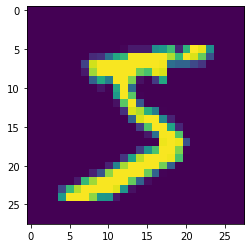

In [7]:
imgplot1 = plt.imshow(x_train[0].copy().reshape(28,28)) # Original image

Recovered image for p = 50:


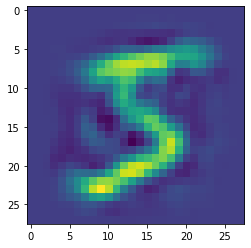

Recovered image for p = 250:


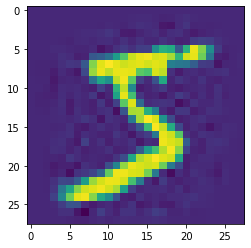

Recovered image for p = 500:


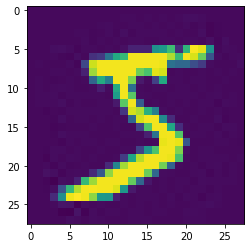

In [8]:
for p in List_p:
  P = np.transpose(np.array([eigenvectors_tri[i] for i in range(p)]))
  Y = np.dot(mean_sub_x, P)
  X_estimate = np.dot(Y,np.transpose(P)) + mean_matrix
  print("Recovered image for p = {}:".format(p))
  plt.imshow(X_estimate[0].copy().reshape(28,28))
  plt.show()

When p decreases, the quality of the recovered image decreases too but the dimensionality of the data set also decreases. Therefore, we have to choose carefully the value of p in order to have a acceptable quality and to minimize the dimensionality of the data set. 
We plot the evolution of the error according to $p$ in order to find this trade-off:

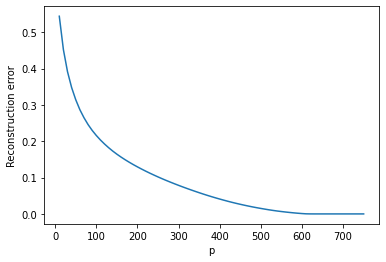

In [9]:
List_p, List_ep = [i*10 for i in range(1,76)], []
for p in List_p:
  P = np.transpose(np.array([eigenvectors_tri[i] for i in range(p)]))
  Y = np.dot(mean_sub_x, P)
  X_estimate = np.dot(Y,np.transpose(P)) + mean_matrix
  List_ep.append(np.linalg.norm(X_estimate - x_train)/np.linalg.norm(x_train))

plt.plot(List_p, List_ep)
plt.xlabel("p")
plt.ylabel("Reconstruction error")
plt.show()

## PCA for image denoising

We generate a noisy data by adding a Gaussian noise with zero mean and chosen variance.

In [10]:
sigma2 = 0.25

x_train_noise = x_train.copy()
for image in x_train_noise:
  for i in range(image.shape[0]):
    image[i] += np.random.normal(0, sigma2)

Let's visualize the corrupted images and the corresponding original images:

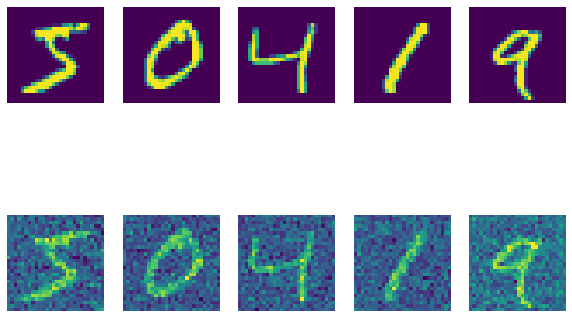

In [11]:
fig = plt.figure(figsize=(10, 7))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(x_train[i].reshape(28,28))
  plt.axis('off')
for i in range(5):
  fig.add_subplot(2, 5, 5 + i+1)
  plt.imshow(x_train_noise[i].reshape(28,28))
  plt.axis('off')

We generate the noisy data for each $\sigma^2 \in \{ 0.15, 0.25, 0.5\}$. Then, we apply the PCA via Eigendecomposition for each $\sigma^2$ and fixing $p = 250$.

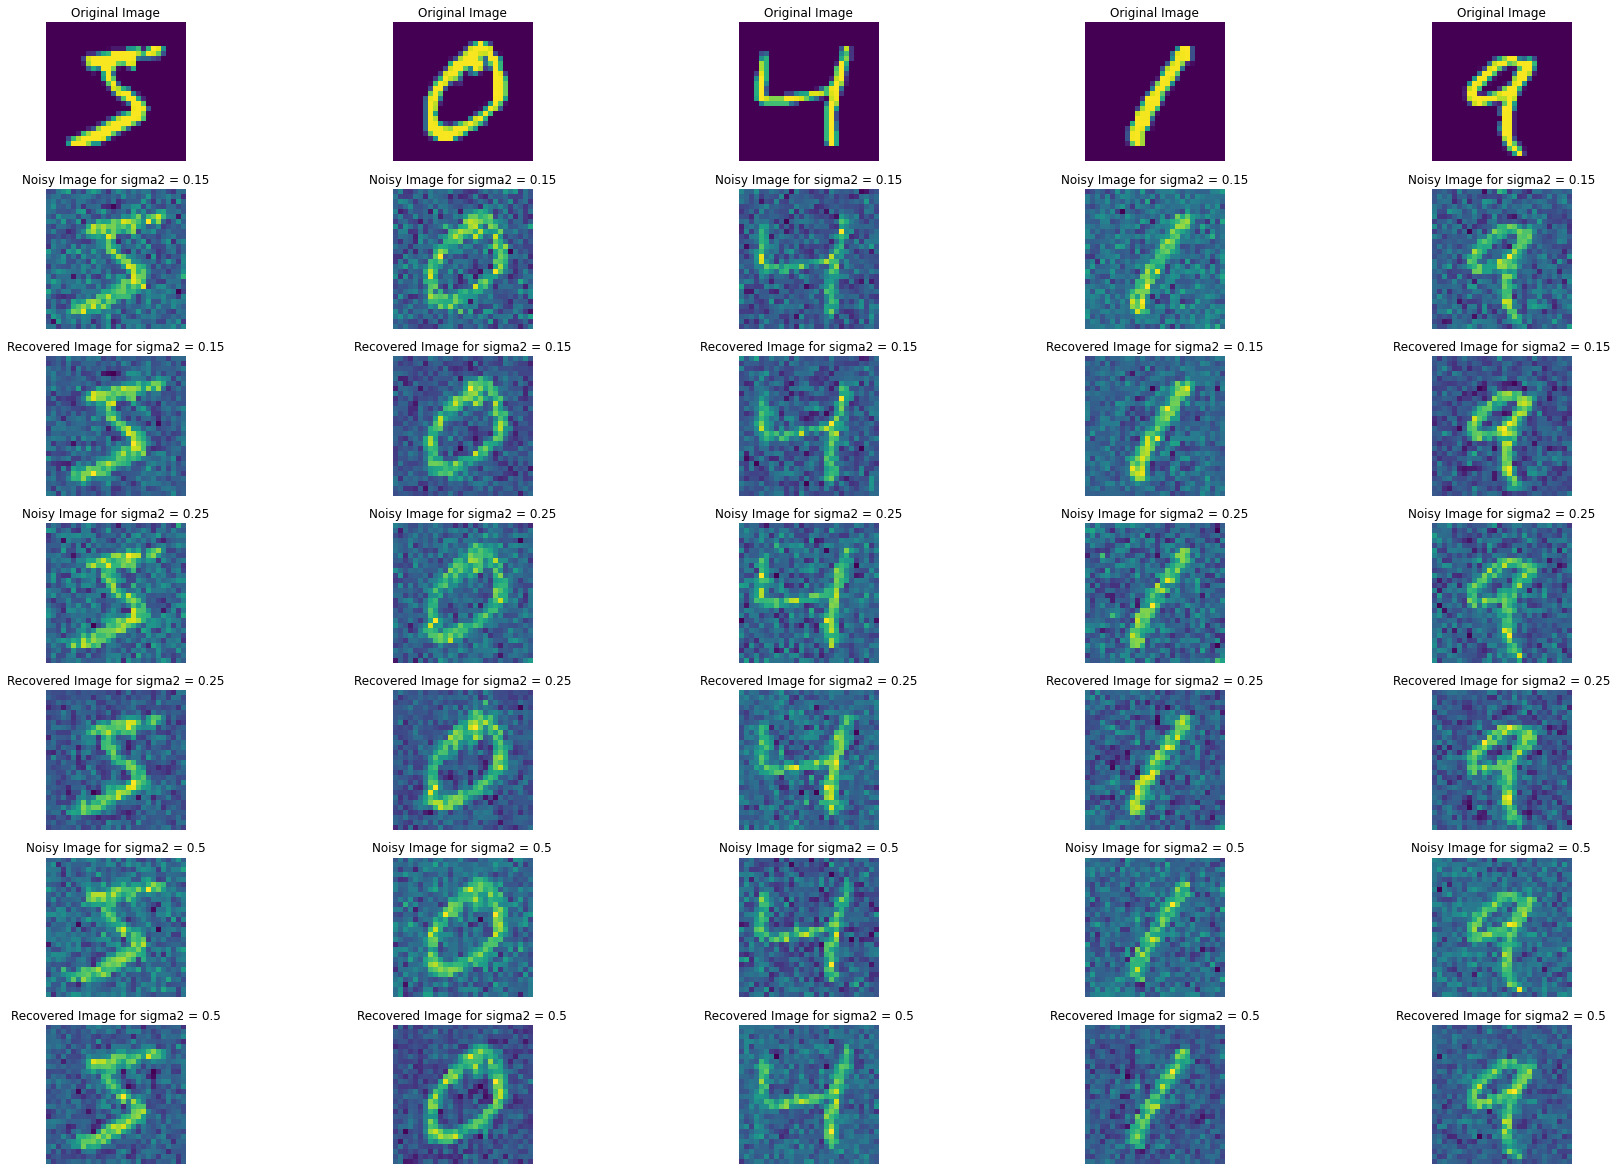

In [12]:
p, List_sigma2, List_ep = 250, [0.15, 0.25, 0.5], []

fig = plt.figure(figsize=(30, 21))


for i in range(5):
  fig.add_subplot(7, 5, i+1)
  plt.imshow(x_train[i].reshape(28,28))
  plt.title("Original Image")
  plt.axis('off')
  

for indice_sigma, sigma in enumerate(List_sigma2):
  x_train_noise = x_train.copy()
  for image in x_train_noise:
    for i in range(image.shape[0]):
      image[i] += np.random.normal(0, sigma2)


  for i in range(5):
    fig.add_subplot(7, 5, 5*(indice_sigma*2 +1) + i+1)
    plt.imshow(x_train_noise[i].reshape(28,28))
    plt.title("Noisy Image for sigma2 = {}".format(sigma))
    plt.axis('off')

  for i,vector_x in enumerate(x_train_noise):
    mean = sum(vector_x)/vector_x.shape[0]
    for j in range(mean_sub_x[i].shape[0]):
      mean_sub_x[i][j] =  x_train_noise[i][j] - mean
      mean_matrix[i][j] = mean

  cov = np.dot(np.transpose(mean_sub_x), mean_sub_x)

  eigenvalues, eigenvectors = np.linalg.eigh(cov)
  list_eigenvectors, list_eigenvalues = [eigenvectors[:,i] for i in range(eigenvectors.shape[0])], list(eigenvalues)  

  C = list(zip(list_eigenvectors, list_eigenvalues))
  C.sort(key=lambda tup: -tup[1])
  C0, C1 = zip(*C) #Dim d*d (tuple of arrays), d (tuple)
  eigenvectors_tri, eigenvalues_tri = np.array(C0), np.array(C1)
  
  P = np.transpose(np.array([eigenvectors_tri[i] for i in range(p)]))
  Y = np.dot(mean_sub_x, P)
  X_estimate = np.dot(Y,np.transpose(P)) + mean_matrix
  List_ep.append(np.linalg.norm(X_estimate - x_train_noise)/np.linalg.norm(x_train_noise))

  
  for i in range(5):
    fig.add_subplot(7, 5, 5*(indice_sigma*2+2) + i+1)
    plt.imshow(X_estimate[i].reshape(28,28))
    plt.title("Recovered Image for sigma2 = {}".format(sigma))
    plt.axis('off')

The evolution of the error ar given by:

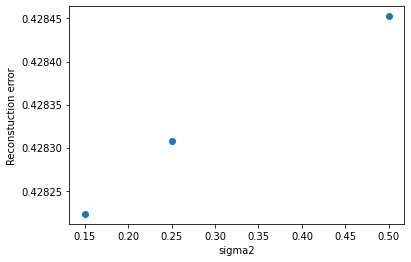

In [13]:
plt.plot(List_sigma2, List_ep, 'o')
plt.xlabel("sigma2")
plt.ylabel("Reconstuction error")
plt.show()

The reconstruction error increases while the variance of the noise increases. This is coherent with the fact that the noise is more powerful

## AdaBoost: Building A Strong Learner from Weak Learners

In this section we will implement an AdaBoost Classifier using the notebook provided:

In [14]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt
from tqdm import tqdm

## Helpers Functions

In [15]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')
    plt.savefig('adaboost.pdf',format='pdf')

In [16]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [17]:
def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f'.format(err))

## Weak Learners

In [18]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train),get_error_rate(pred_test, Y_test)

# Datasets :
##### Generates data for binary classification used in Hastie et al. 2009, Example 10.2.

In [19]:
# Read data
x, y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y

# Split into training and test set
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, Y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [20]:
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
print('Single Weak Learner Achieves \n Train Error of {} \n Test Error of {}'.format(er_tree[0],er_tree[1]))

Single Weak Learner Achieves 
 Train Error of 0.446875 
 Test Error of 0.45875


# Implement an adaboost classifier

In [21]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # Indicator function
        miss = np.where(pred_train_i != Y_train, 1, 0)
        # Equivalent with 1/-1 to update weights
        miss2 = np.sum(np.multiply(w,miss)) 
        # Error
        err_m = miss2/np.sum(w)
        # Alpha
        alpha_m = 0.5*np.log((1-err_m)/err_m)
        # New weights
        w = np.multiply(w,np.exp(alpha_m*miss))
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), get_error_rate(pred_test, Y_test)

# Fit Adaboost classifier using a decision tree as base estimator

100%|██████████| 39/39 [03:41<00:00,  5.68s/it]


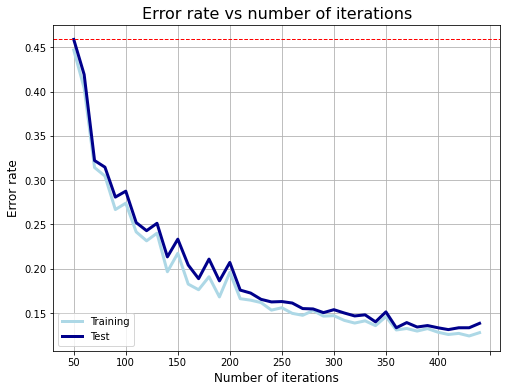

In [22]:
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 400, 10)
for i in tqdm(x_range):
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])
    
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)
